In [31]:
#This file contains the baseline modelling of readmission after discharge. 
#The first chunk is basic preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
import string
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from keras.models import Sequential, load_model
from keras import optimizers
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import itertools
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
nltk.download('punkt')
df_admits = pd.read_csv('/Users/11kolop/MIMIC-III/ADMISSIONS.csv')
df_notes = pd.read_csv('/Users/11kolop/MIMIC-III/NOTEEVENTS.csv')
df_admits.ADMITTIME = pd.to_datetime(df_admits.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_admits.DISCHTIME = pd.to_datetime(df_admits.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_admits.DEATHTIME = pd.to_datetime(df_admits.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_admits = df_admits.sort_values(['SUBJECT_ID','ADMITTIME'])
df_admits = df_admits.reset_index(drop = True)
df_admits.columns

[nltk_data] Downloading package punkt to /Users/11kolop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [4]:
##Create admission time variable, to be used to create binary target variable later
df_admits['NEXT_ADMIT'] = df_admits.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
df_admits['NEXT_TYPE'] = df_admits.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)
df_admits['NEXT_ADMIT'].quantile(np.arange(0,1,.1))

0.0   2100-08-27 11:37:00
0.1   2113-04-29 09:04:00
0.2   2122-12-22 16:33:00
0.3   2132-07-27 22:21:30
0.4   2142-02-15 02:27:00
0.5   2151-10-15 18:23:00
0.6   2162-01-18 13:00:00
0.7   2172-07-27 15:57:30
0.8   2182-07-15 15:12:00
0.9   2193-04-09 15:37:00
Name: NEXT_ADMIT, dtype: datetime64[ns]

In [5]:
#Do not use elective readmissions
rows = df_admits.NEXT_TYPE == 'ELECTIVE'
df_admits.loc[rows,'NEXT_ADMIT'] = pd.NaT
df_admits.loc[rows,'NEXT_TYPE'] = np.NaN
df_admits = df_admits.sort_values(['SUBJECT_ID','ADMITTIME'])
df_admits[['NEXT_ADMIT','NEXT_TYPE']] = df_admits.groupby(['SUBJECT_ID'])[['NEXT_ADMIT','NEXT_TYPE']].fillna(method = 'bfill')
df_admits['DAYS']=  (df_admits.NEXT_ADMIT - df_admits.DISCHTIME).dt.total_seconds()/(24*60*60)
df_admits['DAYS'].describe()

count    11399.000000
mean       409.239700
std        639.190363
min        -18.765278
25%         23.976389
50%        120.199306
75%        507.237847
max       4107.968750
Name: DAYS, dtype: float64

In [6]:
#Only utilize discharge notes
df_notes_dis = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']
df_notes_last = (df_notes_dis.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
df_notes_last

,SUBJECT_ID,HADM_ID,ROW_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,3,145834.0,44005,2101-10-31,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2101-10-20**] Discharg...
1,4,185777.0,4788,2191-03-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2191-3-16**] Discharge...
2,6,107064.0,20825,2175-06-15,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2175-5-30**] Dischar...
3,9,150750.0,57115,2149-11-14,NaN,NaN,Discharge summary,Addendum,NaN,NaN,"Name: [**Known lastname 10050**], [**Known fi..."
4,10,184167.0,17390,2103-07-06,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2103-6-28**] Dischar...
5,11,194540.0,30120,2178-05-11,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2178-4-16**] ...
6,12,112213.0,50972,2104-08-20,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2104-8-7**] Discharge ...
7,13,143045.0,57099,2167-01-15,NaN,NaN,Discharge summary,Addendum,NaN,NaN,"Name: [**Known lastname 9900**], [**Known fir..."
8,17,161087.0,51783,2135-05-13,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2135-5-9**] D...
9,17,194023.0,51782,2134-12-31,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2134-12-27**] ...


In [7]:
#Merge admissions and notes charts
df_adnotes = pd.merge(df_admits[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS','NEXT_ADMIT','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
df_adnotes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adnotes.groupby('ADMISSION_TYPE').size()
df_adnotes

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS,NEXT_ADMIT,ADMISSION_TYPE,DEATHTIME,TEXT
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NaT,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2101-10-20**] Discharg...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2191-3-16**] Discharge...
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NaT,NEWBORN,NaT,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,NaT,ELECTIVE,NaT,Admission Date: [**2175-5-30**] Dischar...
5,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaN,NaT,NEWBORN,NaT,NaN
6,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,NaN,NaT,NEWBORN,NaT,NaN
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,NaN,NaT,EMERGENCY,2149-11-14 10:15:00,"Name: [**Known lastname 10050**], [**Known fi..."
8,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,NaN,NaT,NEWBORN,NaT,Admission Date: [**2103-6-28**] Dischar...
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2178-4-16**] ...


In [8]:
#Create Target variable (whether a readmission occured within 30 days of discharge)
df_adnotes['OUTPUT_LABEL'] = (df_adnotes.DAYS < 30).astype('int')
df_adnotes = df_adnotes.sample(n = len(df_adnotes), random_state = 42)
df_adnotes = df_adnotes.reset_index(drop = True)
df_adnotes['OUTPUT_LABEL'].describe()

count    58976.000000
mean         0.054717
std          0.227429
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: OUTPUT_LABEL, dtype: float64

In [9]:
#Only analyze patients who did not die in hospital
no_death = df_adnotes.DEATHTIME.isnull()
df_not_death = df_adnotes.loc[no_death].copy()
df_not_death = df_not_death.sample(n = len(df_not_death), random_state = 42)
df_not_death = df_not_death.reset_index(drop = True)

In [10]:
#Training Validation Test Split
df_valid_test=df_not_death.sample(frac=0.20,random_state=42)
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)
df_train_all=df_not_death.drop(df_valid_test.index)
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]
#Use undersampling of negative cases
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

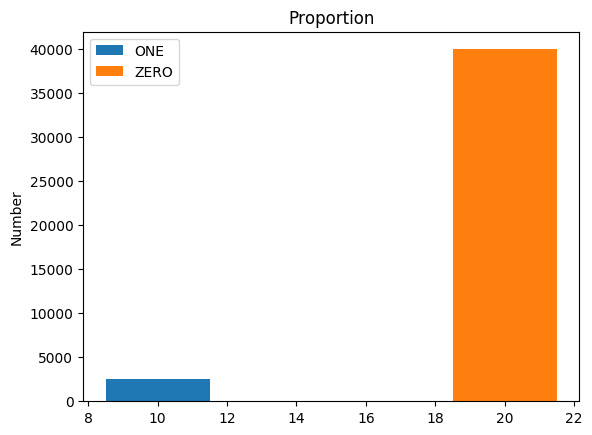

In [11]:
#rationale for undersampling
one_len = df_train_all[df_train_all['OUTPUT_LABEL'] == 1].shape[0]
zero_len = df_train_all[df_train_all['OUTPUT_LABEL'] == 0].shape[0]
plt.bar(10,one_len,3, label="ONE")
plt.bar(20,zero_len,3, label="ZERO")
plt.legend()
plt.ylabel('Number')
plt.title('Proportion')
plt.show()

In [12]:
#Preprocess text (remove nAn,regex characters or escape characters)
def preprocess_text(df):
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT = df.TEXT.str.replace('\n',' ')
    df.TEXT = df.TEXT.str.replace('\r',' ')
    df.TEXT = df.TEXT.str.replace('[^A-Za-z0-9(),!?@\'\`\"\_\n]', ' ')
    return df
df_train = preprocess_text(df_train)
df_test = preprocess_text(df_test)
df_valid = preprocess_text(df_valid)

In [13]:
#Remove stopwords, stem
sw = ['the','and','to','of','was','with','a','on','in','for','name',              
      'is','patient','s','he','at','as','or','one','she','his','her','am',                 
      'were','you','pt','pm','by','be','had','your','this','date',                
      'from','there','an','that','p','are','have','has','h','but','o',                
      'namepattern','which','every','also','should','if','it','been','who','during', 'x']
stemmer = SnowballStemmer("english")
def stemming(text):    
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
df_train['TEXT'] = df_train['TEXT'].apply(stemming)
df_test['TEXT'] = df_test['TEXT'].apply(stemming)
df_valid['TEXT'] = df_valid['TEXT'].apply(stemming)
def tokenizer_better(text):  
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

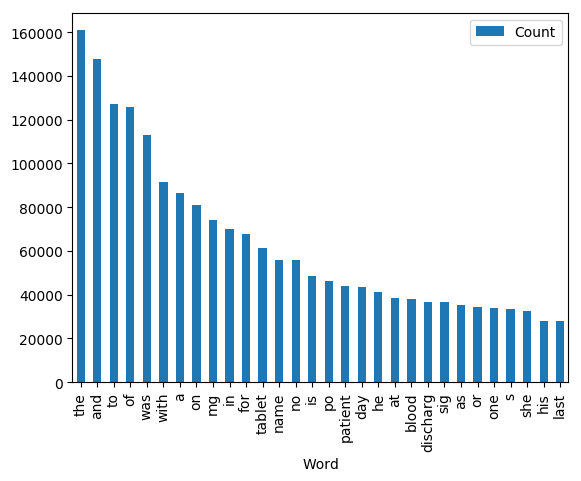

In [22]:
#check most common words before stemming/stopwords
tokens = df_train.apply(lambda row: tokenizer_better(row['TEXT']), axis=1)
tokens =np.concatenate(tokens)
fdist = FreqDist(tokens)
lst = fdist.most_common(30)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')
plt.show()

In [23]:
#Vectorize and fit training and test text
vect = CountVectorizer(tokenizer = tokenizer_better, stop_words =sw, min_df = 5, max_df =.9,)
vect.fit(df_train.TEXT.values.astype('U'))
dictionary = vect.vocabulary_.items() 
X_train_tf = vect.transform(df_train.TEXT.values.astype('U'))
X_test_tf = vect.transform(df_test.TEXT.values.astype('U'))
X_valid_tf = vect.transform(df_valid.TEXT.values.astype('U'))
y_train = df_train.OUTPUT_LABEL
y_test = df_test.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

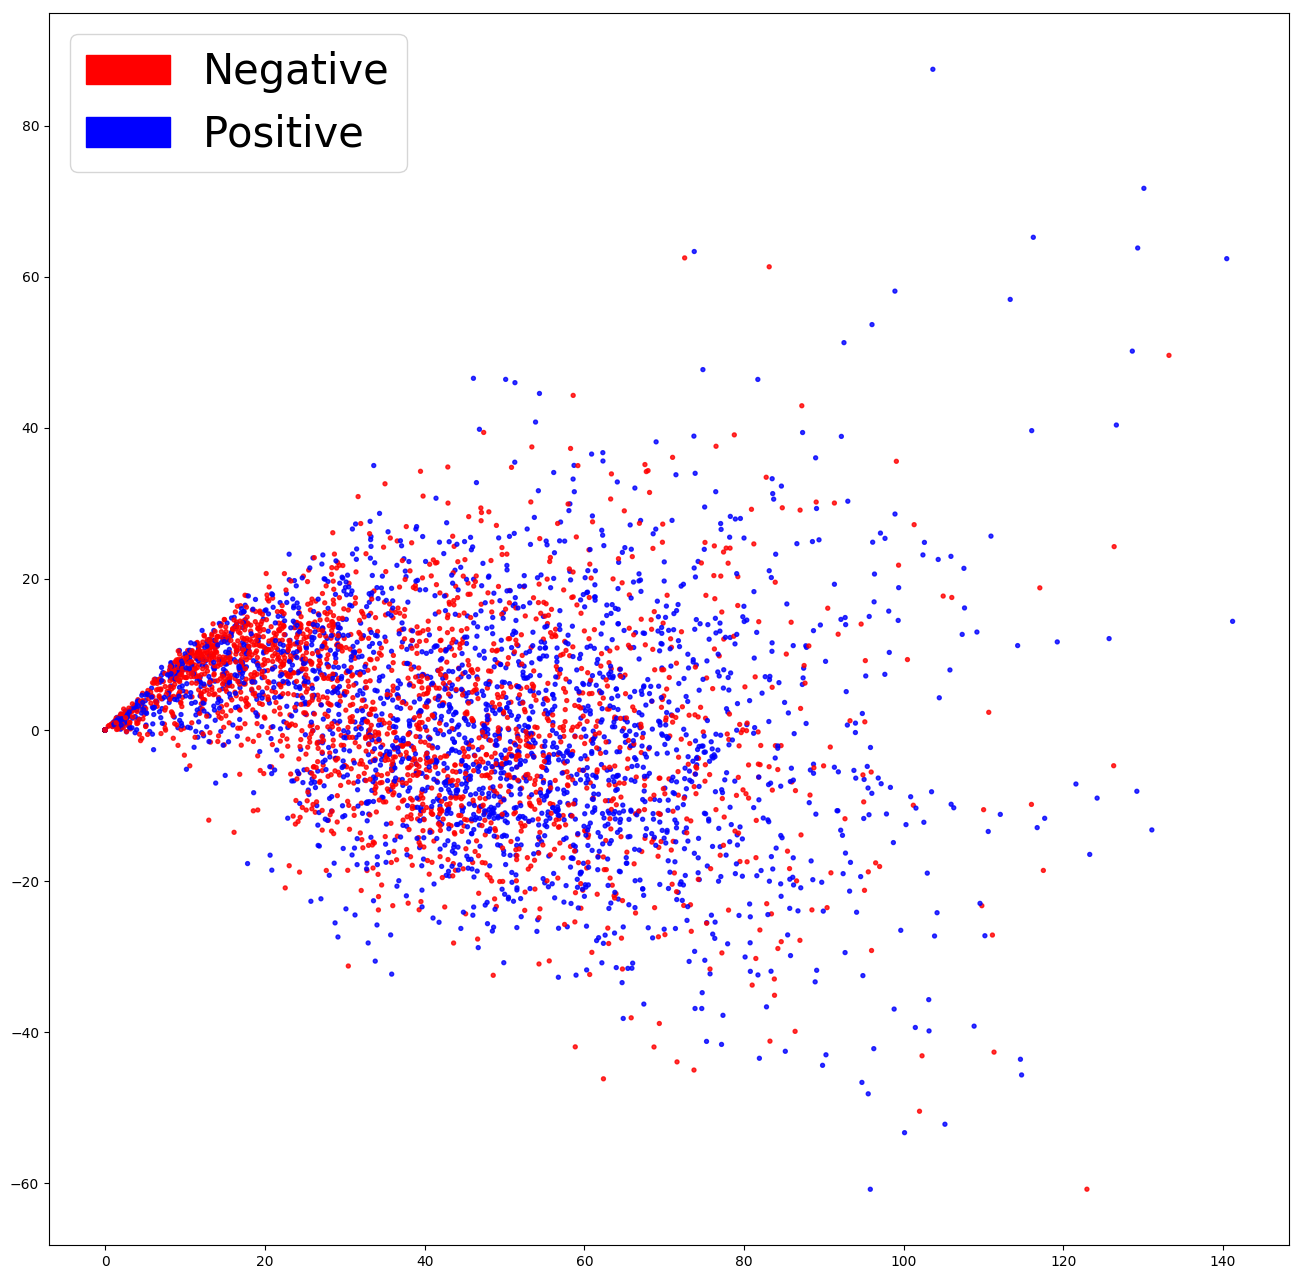

In [24]:
#PCA approximation
#Visually, there is not clear separation between targets in a low dimension representation. 
#Thus, simple models which require separation will not be appropriate.
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['red','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='red', label='Negative')
            green_patch = mpatches.Patch(color='blue', label='Positive')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tf, y_train)
plt.show()

In [25]:
#Confusion Matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)  
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)  
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    return plt


In [26]:
#Pull feature importance from coefficient values of a logistic model
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}   
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes


In [27]:
#Plotting the words from the above function
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]   
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]  
    fig = plt.figure(figsize=(10, 10))  
    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)    
    plt.subplots_adjust(wspace=0.8)
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


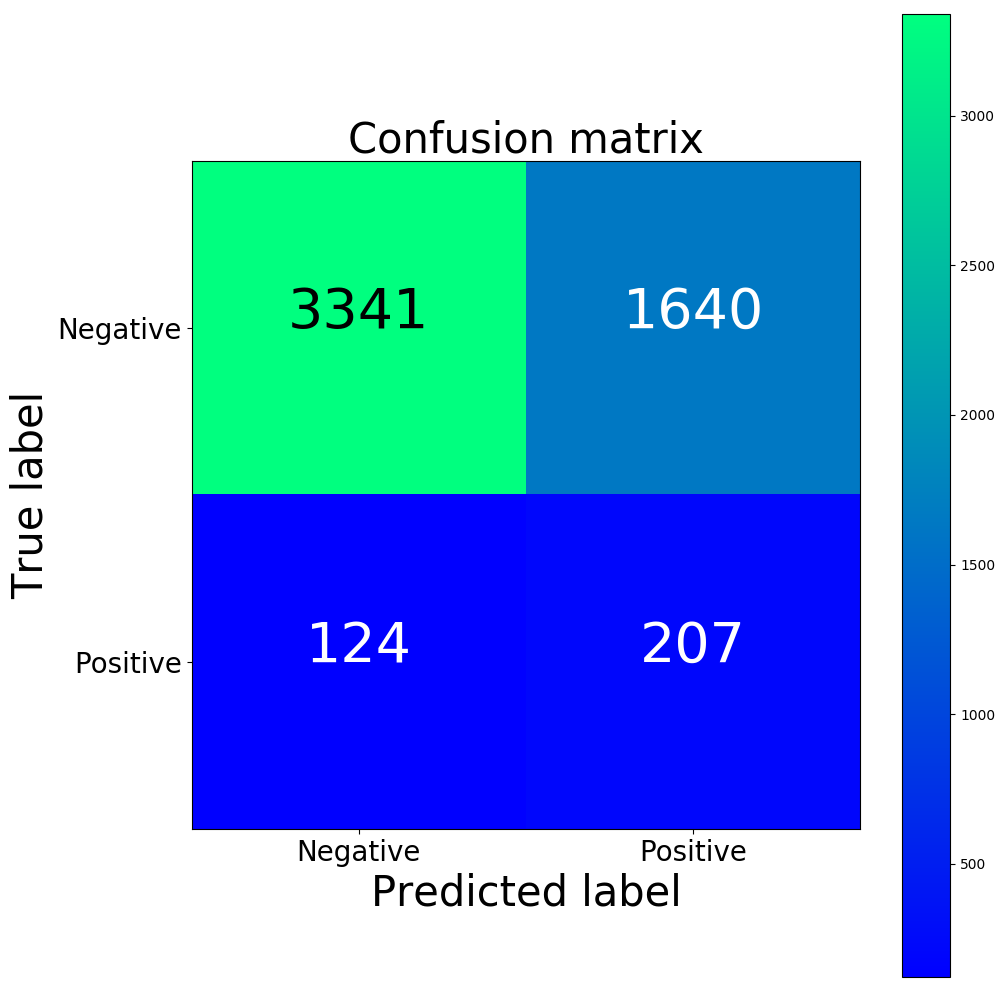

[[3341 1640]
 [ 124  207]]
0.6679216867469879
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      4981
           1       0.11      0.63      0.19       331

   micro avg       0.67      0.67      0.67      5312
   macro avg       0.54      0.65      0.49      5312
weighted avg       0.91      0.67      0.75      5312



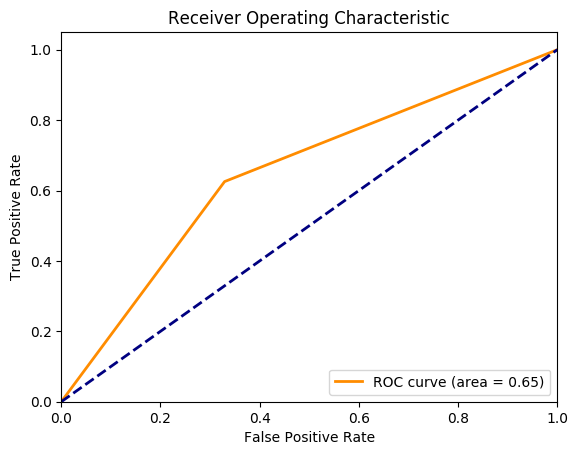

In [28]:
#Baseline logistic model, including confusion matrix and roc curve
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]
decisions = (y_valid_preds >= .5).astype(int)
cm = confusion_matrix(y_valid, decisions)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)
print(accuracy_score(y_valid, decisions, normalize=False) / float(y_valid.size))
print(classification_report(y_valid, decisions))
fpr, tpr, _ = roc_curve(y_valid, decisions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

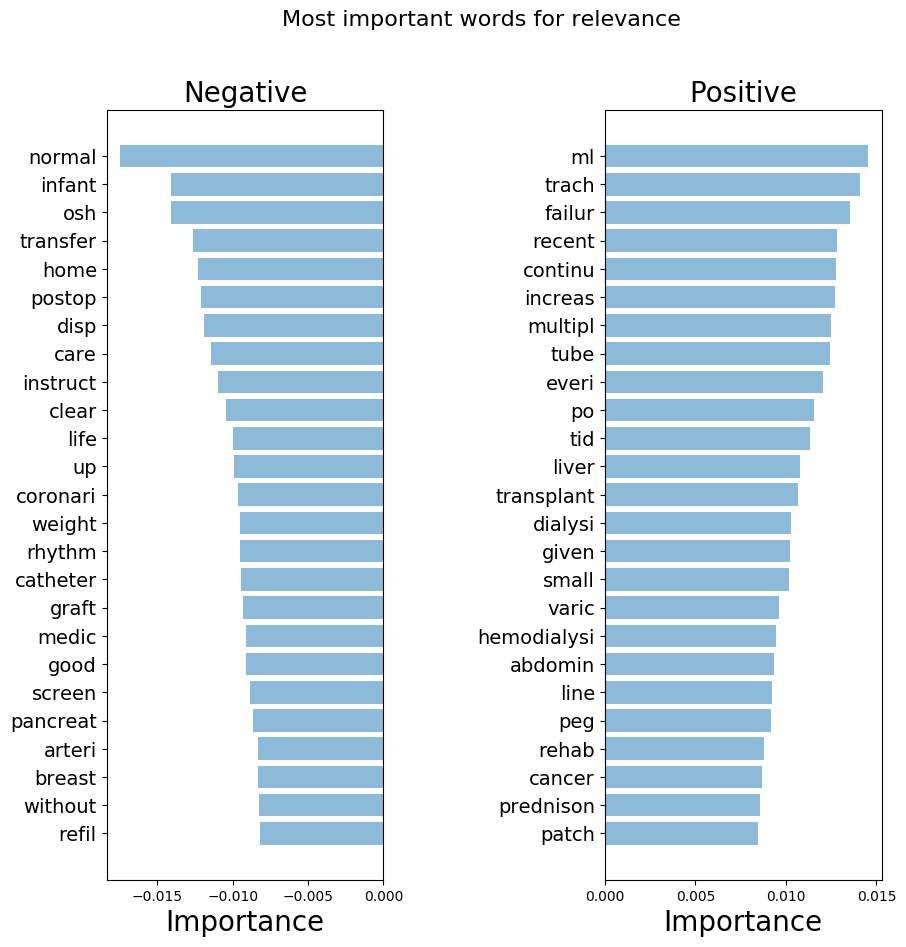

In [29]:
#Important word coefficients from logistic model
importance = get_most_important_features(vect, clf, 25)
top_scores = [a[0] for a in list(importance.values())[0]['tops']]
top_words = [a[1] for a in list(importance.values())[0]['tops']]
bottom_scores = [a[0] for a in list(importance.values())[0]['bottom']]
bottom_words = [a[1] for a in list(importance.values())[0]['bottom']]
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 47.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 66.4min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 79.6min finished


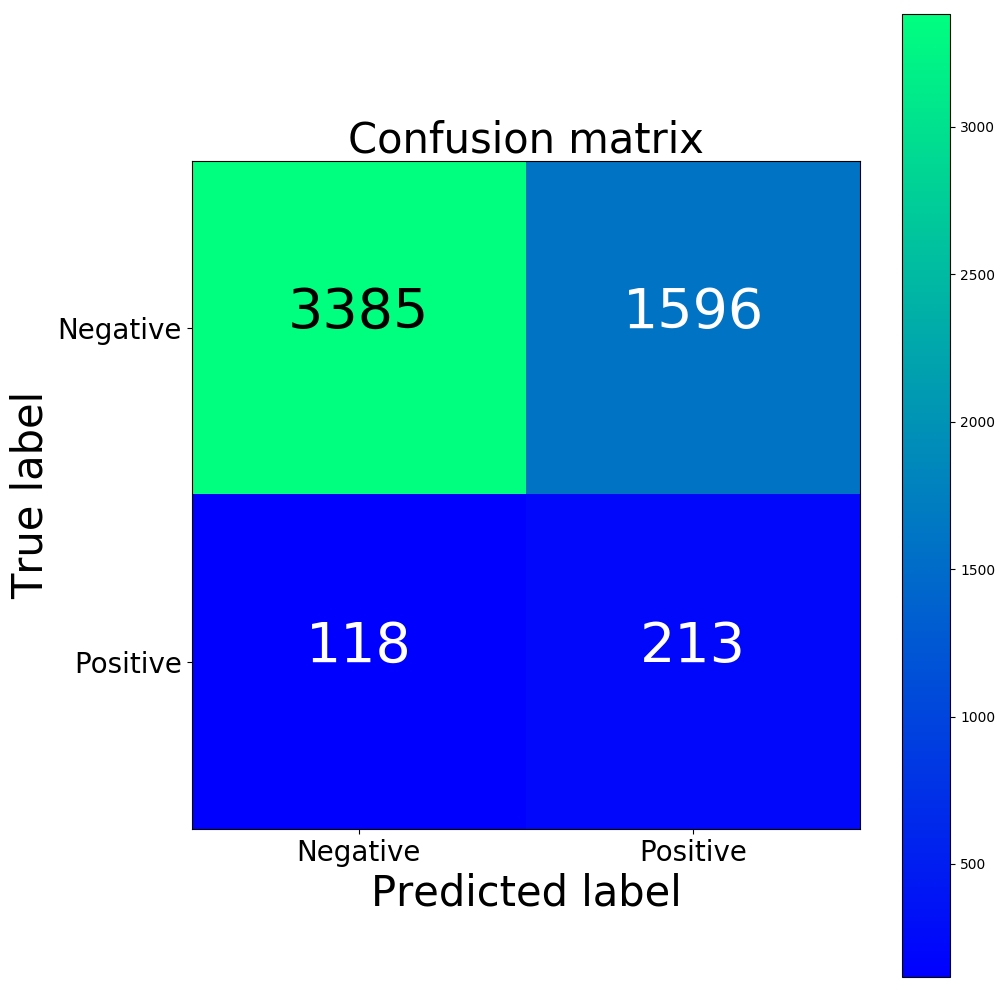

[[3341 1640]
 [ 124  207]]
0.6773343373493976
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      4981
           1       0.12      0.64      0.20       331

   micro avg       0.68      0.68      0.68      5312
   macro avg       0.54      0.66      0.50      5312
weighted avg       0.91      0.68      0.76      5312



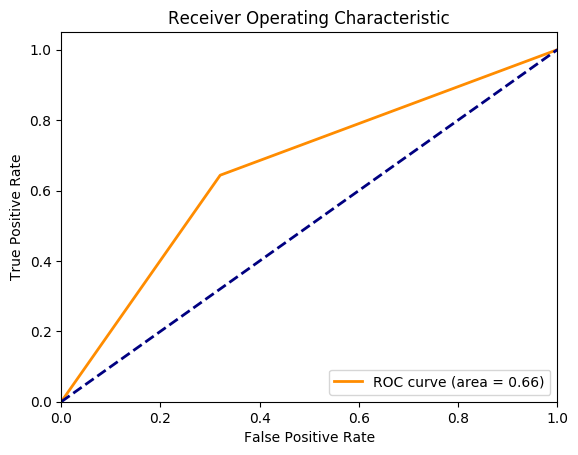

In [32]:
#XGBoost Model Parameter Tuning
#Comparison to XGBoost model, including confusion matrix and roc curve

model = XGBClassifier()
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_train_tf, y_train)
grid_search.best_estimator_
#XGBoost Model
model = XGBClassifier()
model.fit(X_train_tf, y_train)
y_pred = model.predict(X_valid_tf)
pres = [round(value) for value in y_pred]
cm1 = confusion_matrix(y_valid, pres)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm1, classes=['Negative','Positive'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)
print(accuracy_score(y_valid, pres, normalize=False) / float(y_valid.size))
print(classification_report(y_valid, pres))
fpr, tpr, _ = roc_curve(y_valid, pres)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


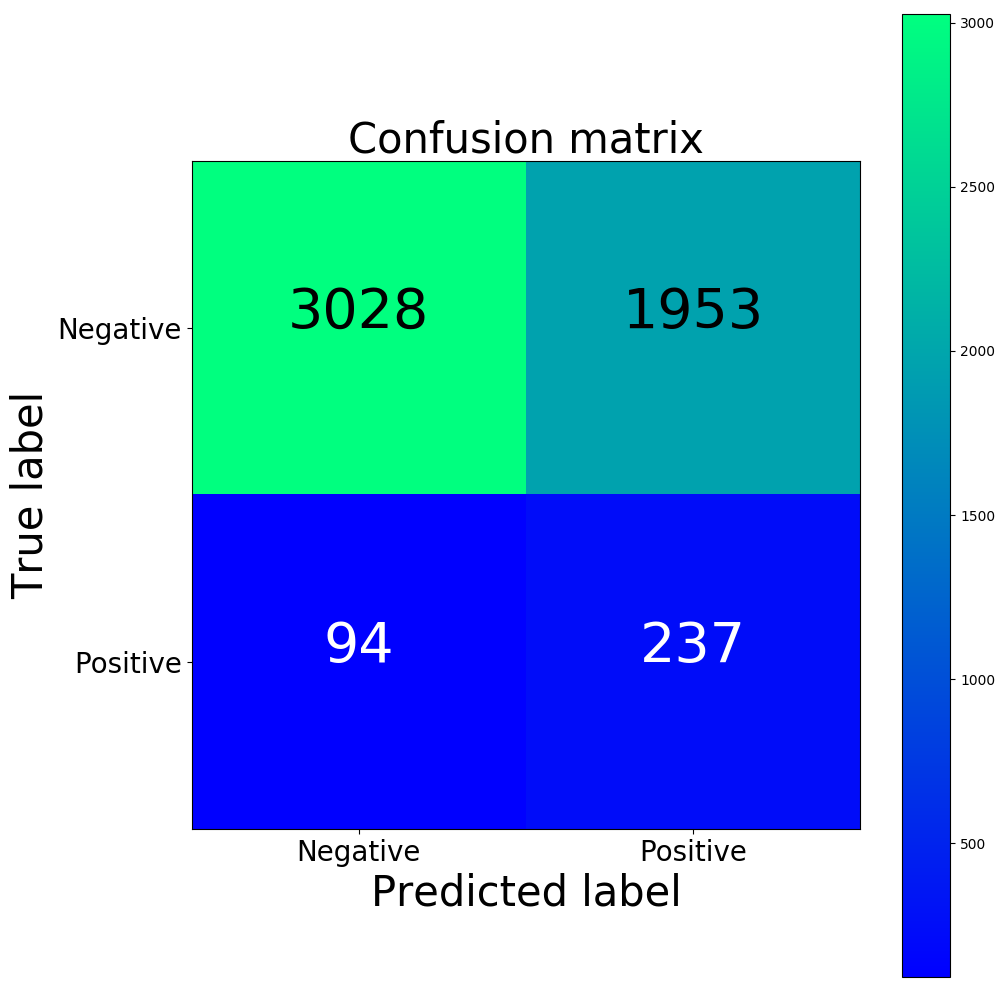

[[3341 1640]
 [ 124  207]]
0.6146460843373494
              precision    recall  f1-score   support

           0       0.97      0.61      0.75      4981
           1       0.11      0.72      0.19       331

   micro avg       0.61      0.61      0.61      5312
   macro avg       0.54      0.66      0.47      5312
weighted avg       0.92      0.61      0.71      5312



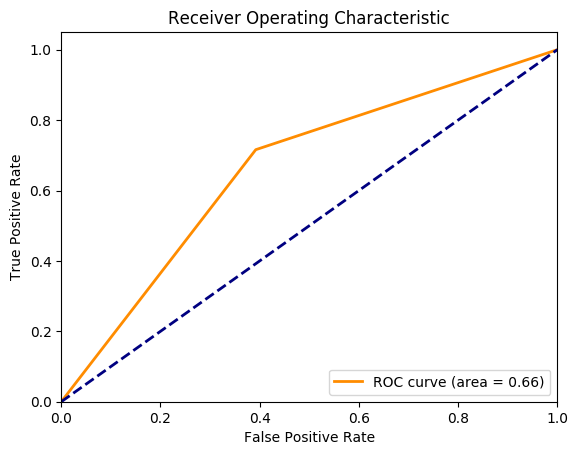

In [33]:
#Comparison to RandomForest model, including confusion matrix and roc curve
clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_train_tf,y_train)
y_pred=clf.predict(X_valid_tf)
cm2 = confusion_matrix(y_valid, y_pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Negative','Positive'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)
print(accuracy_score(y_valid, y_pred, normalize=False) / float(y_valid.size))
print(classification_report(y_valid, y_pred))
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()